In [1]:
import sys
import os
sys.path.append('/home/franzi/anzeigendaten/python_base/skillextraktion/fh_ma')
sys.path.append('/home/franzi/anzeigendaten/EnvPython')
import prepare_training_data
from labels import *
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

start = time.time()
x_train, y_train, x_test, y_test, test_afks, features = prepare_training_data.get_training_data(window=3, pos=True)
print('took: ',time.time()-start)

20861874
0
skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 100
init /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
using data from  /home/franzi/Documents/data/data_pos_3_vecDim100
loading data...
37917 37917 12106 12106 0 0
took:  3.2526392936706543


In [3]:
import numpy as np
for i,f in enumerate(features):
    features[i] = np.array(f)
pos_test, wf_test, bg_test, pos_train, wf_train, bg_train,  _, _, _ = features

print(pos_train[0]) # ADJA first
print(y_train[0])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 1.]


In [4]:
pos_test = np.reshape(pos_test, (pos_test.shape[0], pos_test.shape[2]))
pos_train = np.reshape(pos_train, (pos_train.shape[0], pos_train.shape[2]))

In [6]:
from tensorflow.keras import *

In [8]:
# Build the model
print('Build model...')

vector_window_input = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
vw = layers.LSTM(256, return_sequences=True)(vector_window_input)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512, return_sequences=True)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.Dense(128, activation='relu')(vw)

pos_input = layers.Input(shape=(len(pos_train[0])))
p = layers.Dense(256, activation='relu')(pos_input)
p = layers.Dropout(0.5)(p)
p = layers.Dense(512, activation='relu')(p)
p = layers.Dense(256, activation='relu')(p)

x = layers.concatenate([vw, p])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

out = layers.Dense(units=len(labels), activation='softmax')(x)
model = models.Model(inputs=[vector_window_input, pos_input], outputs=[out])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.evaluate(x=[x_test, pos_test], y=y_test)

batch_size=32
history = model.fit([x_train, pos_train], y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=([x_test, pos_test], y_test))

2020-08-19 11:20:23 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Build model...
12106/12106 [==============================] - 30s 2ms/sample - loss: 2.0818 - acc: 0.0659
Train on 37917 samples, validate on 12106 samples


2020-08-19 11:20:57 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
37917/37917 [==============================] - 221s 6ms/sample - loss: 0.8020 - acc: 0.6964 - val_loss: 0.6946 - val_acc: 0.7399
Epoch 2/5
37917/37917 [==============================] - 217s 6ms/sample - loss: 0.5994 - acc: 0.7804 - val_loss: 0.5160 - val_acc: 0.8191
Epoch 3/5
37917/37917 [==============================] - 216s 6ms/sample - loss: 0.4796 - acc: 0.8295 - val_loss: 0.4624 - val_acc: 0.8418
Epoch 4/5
37917/37917 [==============================] - 221s 6ms/sample - loss: 0.4307 - acc: 0.8501 - val_loss: 0.4296 - val_acc: 0.8554
Epoch 5/5
37917/37917 [==============================] - 208s 5ms/sample - loss: 0.4034 - acc: 0.8600 - val_loss: 0.4230 - val_acc: 0.8567


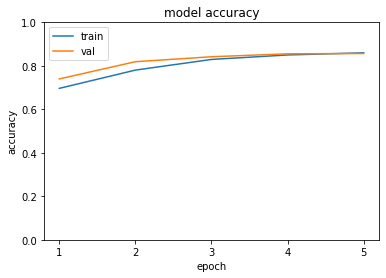

In [9]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['acc'])
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.xticks(np.arange(1, len(history.history['acc'])+1))
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [10]:
# predict test data
y_pred = model.predict([x_test, pos_test])

In [ ]:
import numpy as np
# convert one hot to labels for test data
pred_label = prepare_training_data.one_hot_to_labels(y_pred)
true_label = prepare_training_data.one_hot_to_labels(y_test)

In [12]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label, average=None))/len(list(precision_score(true_label, pred_label, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label, average=None)/8))
print('recall average: ',sum(recall_score(true_label, pred_label, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label))

|           |   Ausbildung |    Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+----------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.764253 | 0.541667 |    0.495017 |     0.690452 |  0.909502 |      0.811005 |    0.796358 |  0.929336 |
| recall    |     0.898551 | 0.203125 |    0.412742 |     0.638476 |  0.905405 |      0.874839 |    0.888273 |  0.92433  |
| f1        |     0.825978 | 0.295455 |    0.450151 |     0.663448 |  0.907449 |      0.841713 |    0.839808 |  0.926826 |
f1 average:  0.7188534994000323
f1 average:  0.6527587883018696
Precision average:  0.7421985651903176
recall average:  0.7182176723180218
acc 0.8566826367090699


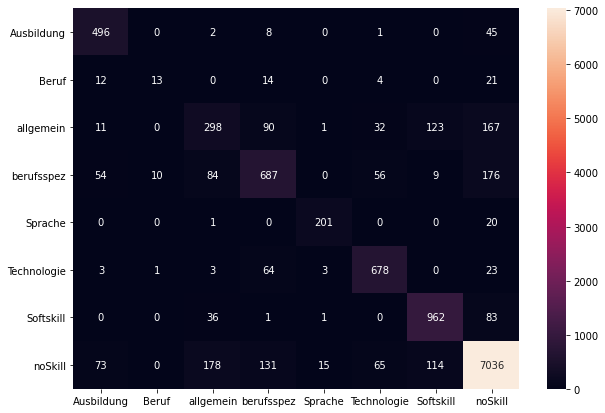

In [13]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')

In [14]:
# clean noSkill for evaluation
clean_y_pred = []
clean_y_test = []
true_noSkills = 0
clean_x_test = []
afks = []

for i in range(len(y_test)):
    if(true_label[i] != 7 or pred_label[i] != 7):
        clean_x_test.append(x_test[i])
        clean_y_pred.append(pred_label[i])
        clean_y_test.append(true_label[i])
        afks.append(test_afks[i])
    else:
        true_noSkills += 1
pred_label = clean_y_pred
true_label = clean_y_test
print('correctly labeled noSkills: ', true_noSkills)

correctly labeled noSkills:  7036


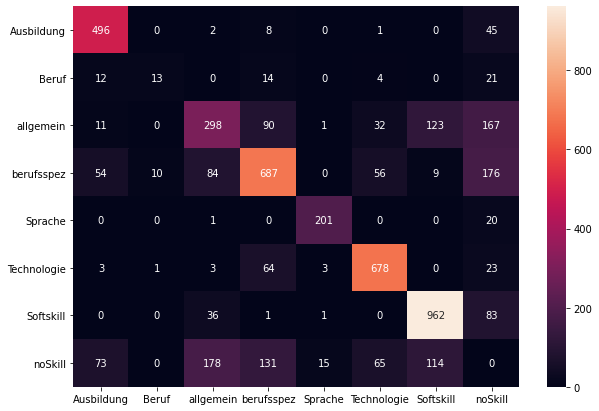

In [15]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')

In [16]:
from word2vec import W2V
correct = []
false = []

clean_x_test, pred_label, true_label, afks = shuffle(clean_x_test, pred_label, true_label, afks,random_state=0)
skill_index = int(len(clean_x_test[0])/2)
label_list = list(labels.keys())


In [17]:
headers = [['|']+[l] for l in label_list ]
headers = sum(headers, [])
headers.append('|')

wvs = []
for i in range(len(clean_x_test)):
    wvs.append(clean_x_test[i][skill_index])

w2v = W2V(skipgram=True, punctuation_marks=False, stoppwords=False, multiword=False, lower_case=False, vector_dim=100)

predictions = [[],[],[],[],[],[],[], []]
for i in range(len(clean_x_test)):
    word = w2v.get_closest_word_to_vec(wvs[i])[0][0]
    label = str(true_label[i])
    predictions[pred_label[i]].append(word + '('+label+')')
    
table = []
# format
i = 0
while(i < len(predictions[0]) or i < len(predictions[1]) or i < len(predictions[2]) or i < len(predictions[3]) or i < len(predictions[4]) or i < len(predictions[5] or i < len(predictions[6]))):
    row = ['|']
    for x in predictions:
        if(len(x) > i and len(x[i]) <  25): 
            row.append(x[i])
            row.append('|')
        else:
            row.append('')
            row.append('|')
            
    table.append(row)
    i+=1    

print(tabulate(table, headers=headers))

skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 100
init /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
|    Ausbildung                |    Beruf                     |    allgemein                 |    berufsspez                |    Sprache                   |    Technologie               |    Softskill                 |    noSkill                   |
---  ------------------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---
|    Zerspanungsmechaniker(0)  |    Serviceberater(1)         |    IT-Affinität(7)           |    CNC-Drehmaschinen(5)      |    Englischkenntnisse(4)     |    Framework(3)              |    Team(6)      